In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import CorrelatedReadoutError
from qiskit.result import CorrelatedReadoutMitigator
from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendSampler

In [2]:
# Run only once to save the account
# IBMProvider.save_account(token='', overwrite=True)

In [3]:
# Connect to the IBM's Quantum backend
provider = IBMProvider()
backend = provider.get_backend('ibm_sherbrooke')
sampler = BackendSampler(backend)

In [4]:
# Set up a local simulator that mimics the real backend
# service = QiskitRuntimeService()
# real_backend = service.backend("ibm_sherbrooke")
# sampler = AerSimulator.from_backend(real_backend)

In [5]:
# check for active account
provider.active_account()

MITIGATION EXPERIMENT SETUP

In [6]:
# Set up the mitigation experiment
qubits = [0,1]
num_qubits = len(qubits)
exp1 = CorrelatedReadoutError(qubits)
exp2 = CorrelatedReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp1.circuits():
    print(c)

for c in exp2.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───

MZI EXPERIMENT SETUP


In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter

In [8]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R')
phi_S = Parameter('phi_S')

In [9]:
# Create quantum registers & classical bits
qr_photon = QuantumRegister(1, 'path')
qr_polarizer = QuantumRegister(1, 'polarization')
cr_detector = ClassicalRegister(1, 'detector')
cr_polarizer = ClassicalRegister(1, 'polarizer')

# Create a quantum circuit 
qc = QuantumCircuit(qr_photon, qr_polarizer, cr_polarizer, cr_detector)

# Polarization BS, creates a superposition and an entanglement with the polarization qubit
qc.h(0)
qc.cx(0,1)

# Phase shift by total of 2π due to the mirrors
# qc.p(pi*2,0)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.rz(phi_R-phi_S,0)

# 2nd BS and a phase shift by π
qc.x(0)
qc.h(0)
qc.x(0)

# photon goes through the polarizing erasers 
qc.barrier()
qc.h(1)

# Measurement 
qc.measure([0,1], [1,0])

# Draw & save the circuit
circuit_image = qc.draw('mpl')
circuit_image.savefig("3.Single_PBS_w_Eraser_circuit.png", dpi=300)
qc.draw('mpl')

In [10]:
# Transpile the circuit
qc_trans = transpile(qc, backend)

COMBINE CIRCUITS

In [11]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [12]:
bound_qc = [] 
exp1_qc = []
exp2_qc = []

# Add the mitigation exp circuits in the list prior to the MZI circuits
for i in range(2**num_qubits):
    exp1_qc.append(exp1.circuits()[i])

# Assign phase shift params from 0 to 2π & add the MZI circuits in the list
for i in range(33):
    param_values = {phi_S: 0, phi_R: (pi/16)*i}
    bound_qc.append(qc_trans.assign_parameters(param_values))

# Add the mitigation exp circuits in the list after the MZI circuits
for i in range(2**num_qubits):
    exp2_qc.append(exp2.circuits()[i])

# Combine all the circuits
all_qc = exp1_qc + bound_qc + exp2_qc
print(len(all_qc)) # Should be 41 in total = 4 prior mitigation circ + 33 MZI circ + 4 post mitigation circ

41


RUN THE EXPERIMENT

In [13]:
# Run on the real backend 
# job = sampler.run(all_qc, shots=shots)
# print(job.job_id())

RETRIEVE THE JOB

In [14]:
# Define job id & retreive the job
job_id = 'ct2t2zkmqj7g008zyg7g'
job = QiskitRuntimeService().job(job_id)
result = job.result()

In [15]:
# Get Mitigation experitment results
exp1_results = [result.get_counts()[i] for i in range(2**num_qubits)]
exp2_results = [result.get_counts()[2**num_qubits+len(bound_qc)+i] for i in range(2**num_qubits)]


# Takes in mitigation experiment results and contructs a assignment matrix
# Returns an assignment matrix
def generate_assignment_matrix(exp_results):
    state_labels = ['00','01', '10', '11']
    assignment_matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for state_idx, state in enumerate(state_labels):
        counts = exp_results[state_idx]
        for measured_state, count in counts.items():
            measured_idx = state_labels.index(measured_state)
            assignment_matrix[measured_idx, state_idx] = count / shots
    return assignment_matrix

# Construct mitigator objects
mitigator1 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp1_results))
mitigator2 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp2_results))

# Get unmitigated counts
unmitigated_counts = [result.get_counts()[2**num_qubits+i] for i in range(len(bound_qc))]

SAVE DATA AS A CSV FILE

In [20]:
# import pandas as pd

# # Convert the counts to a pandas DataFrame
# exp1_df = pd.DataFrame(exp1_results)
# exp2_df = pd.DataFrame(exp1_results)
# counts_df = pd.DataFrame(unmitigated_counts)

# # Add a column for the circuit number
# exp1_df['Circuit Number'] = range(1, len(exp1_df) + 1)
# exp2_df['Circuit Number'] = range(1, len(exp2_df) + 1)
# counts_df['Circuit Number'] = range(1, len(counts_df) + 1)

# # Reorder the columns so that 'Circuit Number' comes first
# exp1_df = exp1_df[['Circuit Number', '00', '01', '10', '11']]
# exp2_df = exp2_df[['Circuit Number', '00', '01', '10', '11']]
# counts_df = counts_df[['Circuit Number', '0 0', '0 1', '1 0', '1 1']]

# # Save the DataFrame to a CSV file
# exp1_df.to_csv('3.pre_mitigation_circ_count.csv', index=False)
# exp2_df.to_csv('3.post_mitigation_circ_count.csv', index=False)
# counts_df.to_csv('3.MZI_circ_counts.csv', index=False)

DEFINE TWO MITIGATION METHODS

In [21]:
# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator)  
# Calculates unmitigated probailities, mitigated quasi-probabilities
# Calculates mitigated probabilities with quasi-probabilites on L2 norm
# Calculates mitigated counts
def mitigation_method_1(mitigator):
    unmitigated_probs, mitigated_quasi_probs, mitigated_probs, mitigated_counts = [], [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigator.quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})
    return unmitigated_probs, mitigated_probs, mitigated_counts


# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator) 
# Calculates unmitigated probailities
# Calculates mitigated quasi-counts by multiplication with inv confusion matrix
# Calculates mitigated counts by throwing away negative counts
# Calculates mitigated probabilites by re-normalizing with new shots #
def mitigation_method_2(mitigator):
    unmitigated_probs, mitigated_probs, mitigated_counts = [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0 0'], unmitigated_counts[i]['0 1'], unmitigated_counts[i]['1 0'], unmitigated_counts[i]['1 1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(mitigator.mitigation_matrix(),vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        total_count = 0
        for i in range(len(vec_count)):
            if mitigated_quasi_count[i] < 0 :mitigated_quasi_count[i] = 0
            total_count += mitigated_quasi_count[i]
        # Define dictionaries
        dict_count = {
            '00': mitigated_quasi_count[0].item(),
            '01': mitigated_quasi_count[1].item(),
            '10': mitigated_quasi_count[2].item(),
            '11': mitigated_quasi_count[3].item()
        }
        dict_prob = {
            '00': (mitigated_quasi_count[0]/total_count).item(),
            '01': (mitigated_quasi_count[1]/total_count).item(),
            '10': (mitigated_quasi_count[2]/total_count).item(),
            '11': (mitigated_quasi_count[3]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)
    return unmitigated_probs, mitigated_probs, mitigated_counts  

Unmitigated Counts: 
{'1 1': 87, '1 0': 3964, '0 1': 3828, '0 0': 313}
Mitigated Counts: 
{'11': 9, '10': 4058, '01': 4124}

Unmitigated Prob: 
{'1 1': 0.0106201171875, '1 0': 0.48388671875, '0 1': 0.46728515625, '0 0': 0.0382080078125}
Mitigated Prob: 
{'11': 0.0011556867114761475, '10': 0.49536883364221607, '01': 0.5034754796463077}


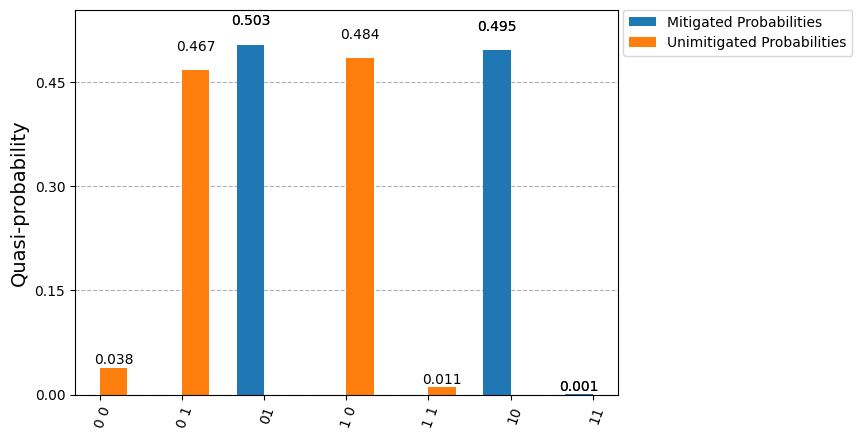

In [22]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
unmitigated_probs, mitigated_probs, mitigated_counts = mitigation_method_1(mitigator1)

# Index of a circuit [0~32: 0=0π, 16=π, 32=2π]
i = 0

# Print unmitigated & mitigated counts and plot 
print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs[i])
print("Mitigated Prob: ")
print(mitigated_probs[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitigated_probs[i]], legend=legend)

SCATTER PLOT OVER ALL ANGLES

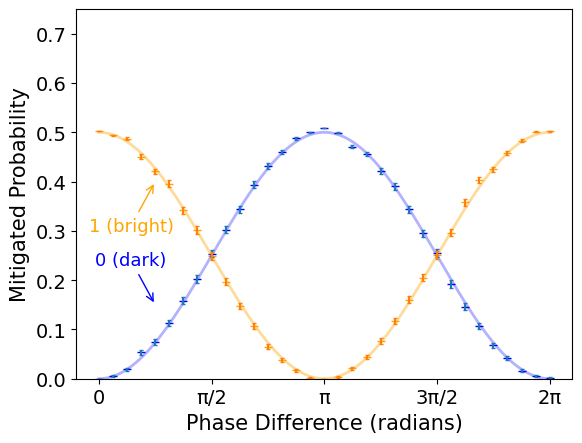

In [38]:
# Extract x, y data 
x_eraser = [(pi/16)*i for i in range(len(mitigated_probs))]
y_0_eraser = [d.get('00', 0) for d in mitigated_probs]
y_1_eraser = [d.get('01', 0) for d in mitigated_probs]

# Calculate standard error (SE = sqrt(p(1-p)/n)) measures how much the probability varies from the true probability.
y_err_eraser = [np.sqrt(y_0_eraser[i] * y_1_eraser[i]/(mitigated_counts[i].get('00',0) + mitigated_counts[i].get('01',0)))*1.96 for i in range (len(mitigated_probs))]

# Theoretical graphs
theta = np.linspace(0, 2*np.pi, 1000)
cos_squared = 0.5*np.cos(theta/2)**2
plt.plot(theta, cos_squared, color='orange', alpha=0.4, linewidth = 2)
sin_squared = 0.5*np.sin(theta/2)**2
plt.plot(theta, sin_squared, color='blue', alpha=0.3,linewidth = 2)

# Create a scatter a scatter plot
plt.errorbar(x_eraser, y_0_eraser, yerr=y_err_eraser, capsize=1.7, linestyle="none")
plt.errorbar(x_eraser, y_1_eraser, yerr=y_err_eraser, capsize=1.7, linestyle="none")
plt.scatter(x_eraser,y_0_eraser, color='blue', label='0 (dark)', marker="_", linewidths=1)
plt.scatter(x_eraser,y_1_eraser, color='orange', label='1 (bright)', marker="_", linewidths=1)

plt.xlabel('Phase Difference (radians)', size = 15)
tick_positions = [(pi/2)*i for i in range(5)]
tick_labels = ['0', 'π/2' , 'π', '3π/2', '2π']
plt.xticks(tick_positions, tick_labels, fontsize = 14)
plt.ylim(0,0.75)
plt.yticks(fontsize = 14)
plt.ylabel('Mitigated Probability', size = 15)
plt.annotate('1 (bright)', xy=(pi/4, 0.4), xytext=(pi/7, 0.3),
             arrowprops=dict(facecolor='orange', edgecolor="orange", arrowstyle='->'),
             fontsize=13, ha='center', color = "orange")
plt.annotate('0 (dark)', xy=(pi/4, 0.15), xytext=(pi/7, 0.23),
             arrowprops=dict(facecolor='blue', edgecolor="blue", arrowstyle='->'),
             fontsize=13, ha='center', color = "blue")
plt.savefig("3.Single_PBS_w_Eraser_result.png", dpi=300)